In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import kornia 
import cv2
from scipy.spatial.distance import cdist
from plot_inlier_matches import *
from skimage.transform import warp, ProjectiveTransform
import kornia

In [2]:
#load both images and convert to grayscale
img1 = plt.imread('parliament-left.jpg')
img2 = plt.imread('parliament-right.jpg')

gray_img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
gray_img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

diff = img1.shape[0] - img2.shape[0]
diff2 = img1.shape[1] - img2.shape[1]

gray_img2padded = np.pad(gray_img2, ((0, diff), (0, diff2)), mode='constant')

#detect keypoints and extract descriptors using cv2
sift = cv2.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(gray_img1, None)
img1_with_keypoints = cv2.drawKeypoints(gray_img1, keypoints1, None)
keypoints2, descriptors2 = sift.detectAndCompute(gray_img2, None)
img2_with_keypoints = cv2.drawKeypoints(gray_img2, keypoints2, None)

In [3]:
# compute Euclidean distances between descriptors
dists = cdist(descriptors1, descriptors2, 'sqeuclidean')

In [4]:
# select top few hundred descriptor pairs with smallest pairwise distance
# extract corresponding keypoints for the inliers
num_pairs = 200
idxs = np.unravel_index(np.argsort(dists, axis=None), dists.shape)
idxs = np.column_stack(idxs)[:num_pairs, :]
kp1 = np.array([keypoints1[idx[0]].pt for idx in idxs])
kp2 = np.array([keypoints2[idx[1]].pt for idx in idxs])

# combine (x,y) coordinates into Nx4 array
inliers = np.hstack((kp1, kp2))

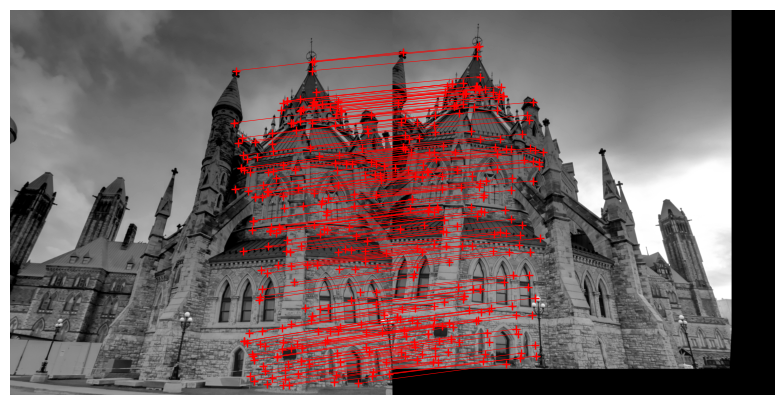

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_inlier_matches(ax, gray_img1, gray_img2padded, inliers)
plt.show()

In [6]:
def affine_transform(src, dst):
    A = np.vstack([src.T, np.ones((1, len(src)))])
    B = np.vstack([dst.T, np.ones((1, len(dst)))])
    X, _, _, _ = np.linalg.lstsq(A.T, B.T, rcond=None)
    return X.T

In [7]:
# minimum number of pairwise matches to estimate affine transformation
min_pairs = 3
# maximum number of RANSAC iterations
max_iters = 100
# radius within which transformed points must lie to be considered inliers
rho = 0.01

# initialize best number of inliers and corresponding affine transformation
best_num_inliers = 0
best_affine_transform = None

# run RANSAC for max_iters iterations
for i in range(max_iters):
    # randomly select min_pairs pairwise matches
    idxs = np.random.choice(num_pairs, size=min_pairs, replace=False)
    # estimate affine transformation using selected pairwise matches
    src_pts = kp1[idxs]
    dst_pts = kp2[idxs]
   
    transform = affine_transform(src_pts, dst_pts)
    
    
    # apply affine transformation to all keypoints in image 1
    kp1_homogeneous = np.hstack((kp1, np.ones((num_pairs, 1))))
    transformed_pts_homogeneous = kp1_homogeneous @ transform.T
    transformed_pts = transformed_pts_homogeneous[:, :2]

    # count number of inliers (transformed points within rho of their corresponding points in image 2)
    distances = np.linalg.norm(transformed_pts - kp2, axis=1)
    num_inliers = np.sum(distances < rho)

    if num_inliers > best_num_inliers:
        best_num_inliers = num_inliers
        best_affine_transform = transform

        
# display number of inliers and best affine transformation
print('Number of inliers:', best_num_inliers)
print('Best affine transformation:\n', best_affine_transform)

Number of inliers: 8
Best affine transformation:
 [[ 9.78396405e-01 -5.12937260e-02 -1.38760504e+03]
 [ 5.12861408e-02  9.78258798e-01 -1.94902664e+02]
 [ 1.31713864e-17 -1.32890778e-17  1.00000000e+00]]


In [8]:
def showImage(img):
    cv2.namedWindow("image", cv2.WINDOW_NORMAL) 
    cv2.resizeWindow('image',600,600)
    cv2.imshow('image', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [9]:
h1, w1 = img1.shape[:2]
h2, w2 = img2.shape[:2]
new_w = w1 + w2
new_h = max(h1, h2)

transform = ProjectiveTransform(matrix=best_affine_transform)
img2_warped = warp(img2, transform, output_shape=(new_h, new_w))

mosaic = img2_warped.copy()
img1 = (img1).astype(np.float32)/255.0
# Copy the first image into the mosaic and overlap onto the other
mosaic[:h1, :w1, :] = img1


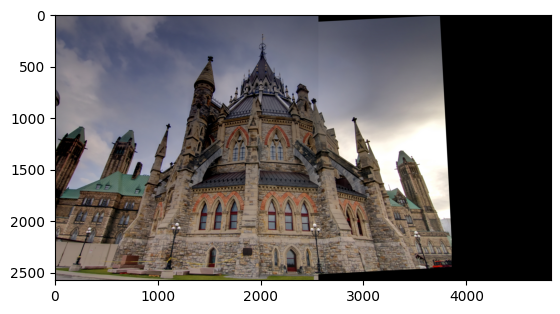

In [10]:
plt.imshow(mosaic)